<a href="https://colab.research.google.com/github/DonaldGubin/Tests/blob/main/1_2_TestTask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Задание 1

import requests
import pandas
KEY – самостоятельно сформировать тестовый

Все запросы, отправляемые к API, должны содержать пользовательский HTTP-заголовок с именем "apikey".
У запроса /historical один параметр - date. Формат YYYY-MM-DD (возвращает json с значениями валют относительно USD на дату)
________________________________________
Запросов ограниченное число - 80 штук
________________________________________
url_history = "https://api.apilayer.com/currency_data/historical"  # Получение данных на дату
headers= {
  "apikey": KEY
}
params = {
    'date': '' # тут значение в формате YYYY-MM-DD
}

В результате необходимо создать таблицу (pandas), в которой по строкам - даты (01.01.2022-07.01.2022), а по столбцам названия из json (первые 10). На пересечении значение на дату


In [1]:
import pandas as pd
import requests

In [2]:
from datetime import datetime, timedelta

In [9]:
#
KEY = 'MA1Hr4AkDLPtyRLWfJ2rdUwlv2K40SNP'

# URL
url_history = "https://api.apilayer.com/currency_data/historical"


headers = {
    "apikey": KEY
}

In [10]:
dates = pd.date_range(start='2022-01-01', end='2022-01-07').strftime('%Y-%m-%d').tolist()

currency_data = {}

request_limit = 80
request_count = 0

for date in dates:
    if request_count >= request_limit:
        print(f"Достигнут лимит запросов: {request_limit}. Остановка.")
        break

    query_params = {
        'date': date
    }

    response = requests.get(url_history, headers=headers, params=query_params)

    print(f"Запрос на {date}: Статус ответа - {response.status_code}")

    try:
        data = response.json()
        if data.get("success"):
            currency_data[date] = data.get("quotes", {})
            request_count += 1
        else:
            print(f"Ошибка при получении данных за {date}: {data.get('error')}")
    except requests.JSONDecodeError:
        print(f"Ошибка декодирования JSON для даты {date}: {response.text}")


Запрос на 2022-01-01: Статус ответа - 200
Запрос на 2022-01-02: Статус ответа - 200
Запрос на 2022-01-03: Статус ответа - 200
Запрос на 2022-01-04: Статус ответа - 200
Запрос на 2022-01-05: Статус ответа - 200
Запрос на 2022-01-06: Статус ответа - 200
Запрос на 2022-01-07: Статус ответа - 200


In [11]:
first_date = dates[0]
currencies = list(currency_data[first_date].keys())[:10]


df = pd.DataFrame(index=dates, columns=currencies)


for date in dates:
    for currency in currencies:
        df.at[date, currency] = currency_data[date].get(currency)


df = df.astype(float)

df

,USDAED,USDAFN,USDALL,USDAMD,USDANG,USDAOA,USDARS,USDAUD,USDAWG,USDAZN
2022-01-01,3.673042,103.750404,106.650403,480.234325,1.802591,550.590403,102.689974,1.375800,1.8000,1.703970
2022-01-02,3.672980,103.749983,106.650326,480.234325,1.802591,550.590435,102.664691,1.376179,1.8000,1.698647
2022-01-03,3.673103,103.750299,106.249880,481.590005,1.802973,554.203977,102.958502,1.389502,1.8005,1.701522
2022-01-04,3.673096,104.899369,105.874950,482.301630,1.801500,553.427992,103.104100,1.381105,1.8000,1.698131
2022-01-05,3.673102,105.250158,106.902530,483.164239,1.802797,552.652983,103.102801,1.384754,1.8005,1.691373
2022-01-06,3.673102,104.999962,107.350118,483.038449,1.802366,551.700853,103.228600,1.395982,1.8000,1.700773
2022-01-07,3.673042,105.000368,107.000368,483.788207,1.802362,550.928041,103.292284,1.392651,1.8005,1.703970


# Задача 2

## Даны значения модели принятия решений. Модель оценивает уровень вероятности дефолта PD
##•	PD – уровень вероятности дефолта Клиента (чем выше уровень, тем больше вероятность, что Клиент не выплатит Кредит)
##•	Статус – Хороший (Клиент закрытыл кредит без просрочек), Дефолт (Клиент не вернул кредит)
## Что необходимо:
посчитать GINI по всей выборке данных, построить график Roc-auc посчитать коэффициент KS (Колмогорова-Смирнова), построить график функции распределения для двух классов


In [13]:
df = pd.read_excel('/content/test_task.xlsx')
df

,PD для 2-х,Статус
0,0.0008,Хороший
1,0.0009,Хороший
2,0.0010,Хороший
3,0.0010,Хороший
4,0.0010,Хороший
...,...,...
389,0.0286,Хороший
390,0.0301,Хороший
391,0.0303,Хороший
392,0.0353,Хороший


In [14]:
import numpy as np
import seaborn as sns
from scipy.interpolate import interp1d
from scipy.integrate import quad
from sklearn.metrics import roc_curve, auc, roc_auc_score
from matplotlib import pyplot as plt
%matplotlib inline


In [15]:
df['Статус'] = df['Статус'].apply(lambda x: 1 if x == 'Дефолт' else 0)

In [17]:
df

,PD для 2-х,Статус
0,0.0008,0
1,0.0009,0
2,0.0010,0
3,0.0010,0
4,0.0010,0
...,...,...
389,0.0286,0
390,0.0301,0
391,0.0303,0
392,0.0353,0


## Gini

In [19]:
roc_auc = roc_auc_score(df['Статус'], df['PD для 2-х'])

gini = 2 * roc_auc - 1
print(f'Gini: {gini:.4f}')

Gini: 0.5683


## График ROC-AUC

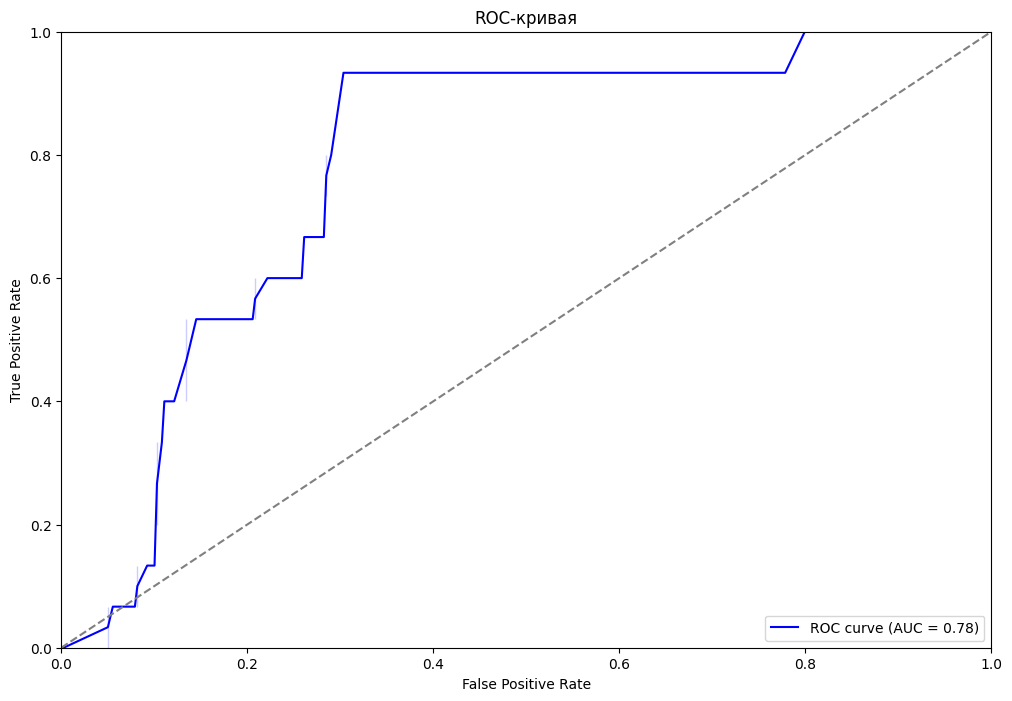

In [25]:
fpr, tpr, thresholds = roc_curve(df['Статус'], df['PD для 2-х'])
roc_auc_value = auc(fpr, tpr)

plt.figure(figsize=(12, 8))
sns.lineplot(x = fpr, y = tpr, label=f'ROC curve (AUC = {roc_auc_value:.2f})', color="blue")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc='lower right')
plt.show()

## Интерполяция и вычисление площади под кривой


In [33]:
f_interp = interp1d(fpr, tpr, kind='linear', fill_value='extrapolate')

fpr_value = 0.2
tpr_value = f_interp(fpr_value)
print(f'При FPR = {fpr_value}, интерполированное TPR = {tpr_value}')

При FPR = 0.2, интерполированное TPR = 0.5333333333333333


In [34]:
auc_quad, _ = quad(f_interp, 0, 1)

print(f'AUC(интегрирование): {auc_quad:.4f}')

AUC(интегрирование): 0.7841


<ipython-input-34-e1569dc255ed>:1: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  auc_quad, _ = quad(f_interp, 0, 1)


In [35]:
auc_sklearn = auc(fpr, tpr)
print(f'AUC (sklearn): {auc_sklearn:.4f}')

AUC (sklearn): 0.7842


In [32]:
for i in range(len(thresholds)):
    print(f'Threshold: {thresholds[i]:.2f}, FPR: {fpr[i]:.2f}, TPR: {tpr[i]:.2f}')

Threshold: inf, FPR: 0.00, TPR: 0.00
Threshold: 0.05, FPR: 0.00, TPR: 0.00
Threshold: 0.01, FPR: 0.05, TPR: 0.00
Threshold: 0.01, FPR: 0.05, TPR: 0.07
Threshold: 0.01, FPR: 0.06, TPR: 0.07
Threshold: 0.01, FPR: 0.06, TPR: 0.07
Threshold: 0.01, FPR: 0.06, TPR: 0.07
Threshold: 0.01, FPR: 0.07, TPR: 0.07
Threshold: 0.01, FPR: 0.07, TPR: 0.07
Threshold: 0.01, FPR: 0.07, TPR: 0.07
Threshold: 0.01, FPR: 0.08, TPR: 0.07
Threshold: 0.01, FPR: 0.08, TPR: 0.07
Threshold: 0.01, FPR: 0.08, TPR: 0.13
Threshold: 0.01, FPR: 0.09, TPR: 0.13
Threshold: 0.01, FPR: 0.10, TPR: 0.13
Threshold: 0.01, FPR: 0.10, TPR: 0.13
Threshold: 0.01, FPR: 0.10, TPR: 0.20
Threshold: 0.01, FPR: 0.10, TPR: 0.33
Threshold: 0.01, FPR: 0.11, TPR: 0.33
Threshold: 0.01, FPR: 0.11, TPR: 0.40
Threshold: 0.01, FPR: 0.12, TPR: 0.40
Threshold: 0.01, FPR: 0.12, TPR: 0.40
Threshold: 0.01, FPR: 0.13, TPR: 0.40
Threshold: 0.01, FPR: 0.13, TPR: 0.53
Threshold: 0.01, FPR: 0.15, TPR: 0.53
Threshold: 0.01, FPR: 0.16, TPR: 0.53
Threshold: 0.

## Коэффициент Колмогорова-Смирнова (KS)

In [41]:
ks = np.max(np.abs(tpr - fpr))
print(f'KS: {ks:.4f}')

KS: 0.6299


## График функции распределение для двух классов


In [27]:
good_clients = df[df['Статус'] == 0]['PD для 2-х']
bad_clients = df[df['Статус'] == 1]['PD для 2-х']

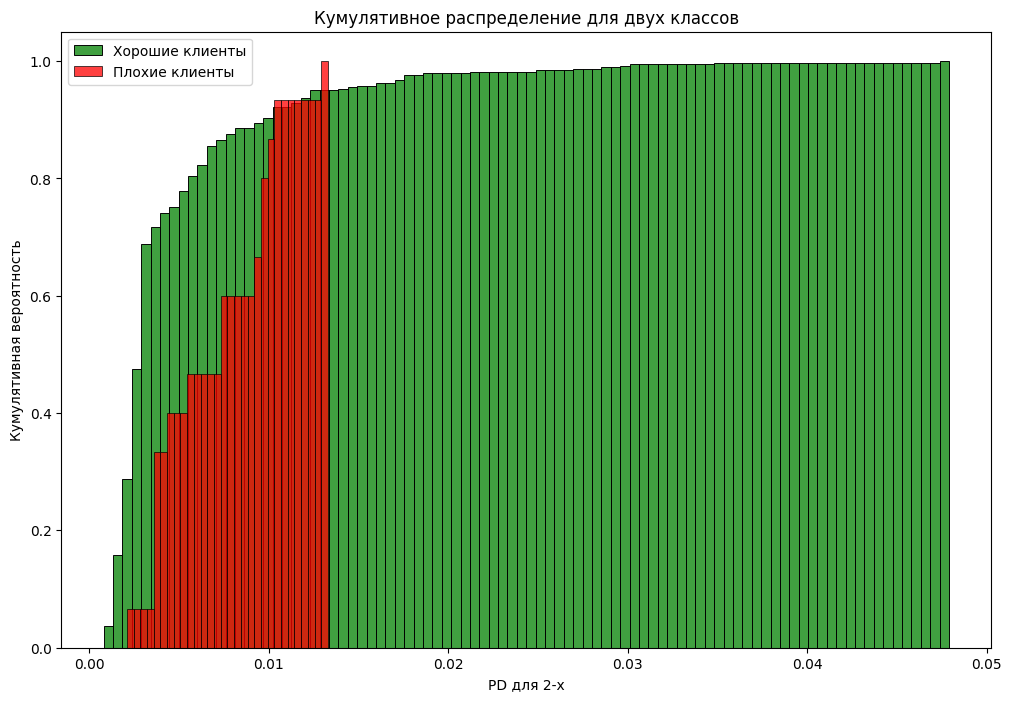

In [40]:
plt.figure(figsize=(12, 8))
sns.histplot(good_clients, bins=90, label='Хорошие клиенты', color='green', stat='density', kde=False, cumulative=True)
sns.histplot(bad_clients, bins=30, label='Плохие клиенты', color='red', stat='density', kde=False, cumulative=True)
plt.xlabel('PD для 2-х')
plt.ylabel('Кумулятивная вероятность')
plt.title('Кумулятивное распределение для двух классов')
plt.legend(loc='upper left')
plt.show()